In [2]:
import cv2
import os
import numpy as np
import tifffile
import cv2
from matplotlib import pyplot as plt
from itertools import product

In [6]:
dir = r"E:\fullimage\images/"
out = r"E:"
flist = os.listdir(dir)

if not os.path.exists(out):
    os.makedirs(out)

if not os.path.exists(dir):
    os.makedirs(dir)

In [7]:
img = []
for file in flist:
    if file == "Thumbs.db":
        pass
    else:
        temp = tifffile.imread(os.path.join(dir + file))
        Nuc = temp[0]
        ecad = temp[7]

        # # Nuc = cv2.resize(Nuc,dsize=(512,512),interpolation=cv2.INTER_NEAREST)
        # Nuc = preprocessing(Nuc)
        
        
        # # ecad = cv2.resize(ecad,dsize=(512,512),interpolation=cv2.INTER_NEAREST)
        # ecad = preprocessing(ecad)
        
        img.append(np.stack([Nuc,ecad]))

In [8]:
for i,items in enumerate(img):
    tifffile.imwrite(os.path.join(out,flist[i]),data=items,dtype='uint8',imagej=True)      

In [83]:
im = img[0][0]
M = im.shape[0]//12
N = im.shape[1]//12
tiles = [im[x:x+M,y:y+N] for x in range(0,im.shape[0],M) for y in range(0,im.shape[1],N)]

In [84]:
np.shape(tiles[0])

(606, 532)

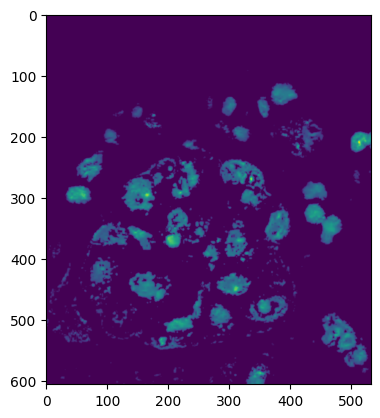

In [86]:
plt.imshow(tiles[3])

# -------------------------------------------------------------------------------------

In [4]:
def split_tiff_into_slices(input_file, output_folder, slice_size=(512, 512), overlap=128):
    # Open the input TIFF file
    image = tifffile.imread(input_file)
    height, width = image.shape  # Adjusted order to match (height, width)

    slice_width, slice_height = slice_size

    # Calculate the number of slices needed
    x_slices = (width - overlap) // (slice_width - overlap) + 1
    y_slices = (height - overlap) // (slice_height - overlap) + 1

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    slice_count = 0

    # Generate the slices
    for i in range(x_slices):
        for j in range(y_slices):
            slices = []
            left = i * (slice_width - overlap)
            upper = j * (slice_height - overlap)
            right = left + slice_width
            lower = upper + slice_height

                # Ensure we don't go out of the image boundaries
            if right > width:
                right = width
                left = width - slice_width
            if lower > height:
                lower = height
                upper = height - slice_height

                # Extract the slice from the image array
            slice_img = image[upper:lower, left:right]
            slices.append(slice_img)

            # Convert slices list to numpy array and save it as a multi-page TIFF file
            slices_array = np.stack(slices)
            slice_count += 1
            output_file = os.path.join(output_folder, f'slice_{slice_count}.tiff')
            tifffile.imwrite(output_file, slices_array)

    print(f'Total {slice_count} slices saved in {output_folder}')

# Example usage
input_file = r"C:\Users\miles\Desktop\d\Mx_SA TMA 5_J01.ome.tiff"
output_folder = r'C:\Users\miles\Desktop\e'
split_tiff_into_slices(input_file, output_folder)

Total 72 slices saved in C:\Users\miles\Desktop\e


In [17]:
def split_tiff_into_slices(input_file, output_folder, slice_size=(512, 512), overlap=128):
    """
    Split a multi-page TIFF image into smaller slices and save them as individual TIFF files.

    Args:
        input_file (str): Path to the input TIFF file.
        output_folder (str): Path to the output folder where slices will be saved.
        slice_size (tuple): Size of each slice (width, height).
        overlap (int): Overlap between adjacent slices.

    Returns:
        None
    """
    if not os.path.exists(input_file):
        raise FileNotFoundError(f"Input file '{input_file}' does not exist.")

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    with tifffile.TiffFile(input_file) as tif:
        image = tif.asarray()

    num_images, height, width = image.shape

    slice_width, slice_height = slice_size

    x_slices = (width - overlap) // (slice_width - overlap)
    y_slices = (height - overlap) // (slice_height - overlap)

    slice_count = 0

    for i in range(x_slices):
        for j in range(y_slices):
            slices = []
            for page in range(num_images):
                left = max(0, i * (slice_width - overlap))
                upper = max(0, j * (slice_height - overlap))
                right = min(width, left + slice_width)
                lower = min(height, upper + slice_height)

                slice_img = image[page, upper:lower, left:right]
                slices.append(slice_img)

            slices_array = np.stack(slices)
            slice_count += 1
            output_file = os.path.join(output_folder, f'slice_{slice_count}.tiff')
            tifffile.imwrite(output_file, slices_array,imagej=True)

    print(f'Total {slice_count} slices saved in {output_folder}')

# Example usage
input_file = r'E:\tmp\Mx_BEGIN TMA EDGE_A15.ome.tif'
output_folder = r'E:\slices'
split_tiff_into_slices(input_file, output_folder)

Total 288 slices saved in E:\slices


In [5]:
def split_tiff_into_slices(input_folder, output_folder, slice_size=(512, 512), overlap=64):
    """
    Split multi-page TIFF images in a directory into smaller slices and save them in subfolders.

    Args:
        input_folder (str): Path to the folder containing input TIFF files.
        output_folder (str): Path to the output folder where slices will be saved.
        slice_size (tuple): Size of each slice (width, height).
        overlap (int): Overlap between adjacent slices.

    Returns:
        None
    """
    if not os.path.exists(input_folder):
        raise FileNotFoundError(f"Input folder '{input_folder}' does not exist.")

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        if filename.endswith('.tif') or filename.endswith('.tiff'):
            input_file = os.path.join(input_folder, filename)
            output_subfolder = os.path.join(output_folder, os.path.splitext(filename)[0])
            os.makedirs(output_subfolder, exist_ok=True)

            split_tiff(input_file, output_subfolder, slice_size, overlap)

    print('Slicing completed for all images in the directory.')

def split_tiff(input_file, output_folder, slice_size=(512, 512), overlap=64):
    """
    Split a multi-page TIFF image into smaller slices and save them as individual TIFF files.

    Args:
        input_file (str): Path to the input TIFF file.
        output_folder (str): Path to the output folder where slices will be saved.
        slice_size (tuple): Size of each slice (width, height).
        overlap (int): Overlap between adjacent slices.

    Returns:
        None
    """
   
    image = tifffile.imread(input_file)
        
    image = np.asarray(image)

    height, width = image.shape
   
    slice_width, slice_height = slice_size

    x_slices = (width - overlap) // (slice_width - overlap)
    y_slices = (height - overlap) // (slice_height - overlap)

    slice_count = 0
    
 
    for i in range(x_slices):
        for j in range(y_slices):
            left = max(0, i * (slice_width - overlap))
            upper = max(0, j * (slice_height - overlap))
            right = min(width, left + slice_width)
            lower = min(height, upper + slice_height)

            slice_img = image[upper:lower, left:right]
        
            output_file = os.path.join(output_folder, f'{os.path.splitext(os.path.basename(input_file))[0]}_{left}_{upper}_{right}_{lower}_seg.tiff')
            tifffile.imwrite(output_file, slice_img)
            slice_count += 1
            
                
    print(f'Total {slice_count} slices saved in {output_folder}')
    

# Example usage
input_folder = r'C:\Users\miles\Desktop\d'
output_folder = r"C:\Users\miles\Desktop\e"
split_tiff_into_slices(input_folder, output_folder)

Total 42 slices saved in C:\Users\miles\Desktop\e\Mx_SA TMA 5_J01.ome
Slicing completed for all images in the directory.


In [25]:
def split_tiff_into_slices(input_folder, output_folder, slice_size=(512, 512), overlap=64):
    """
    Split multi-page TIFF images in a directory into smaller slices and save them in subfolders.

    Args:
        input_folder (str): Path to the folder containing input TIFF files.
        output_folder (str): Path to the output folder where slices will be saved.
        slice_size (tuple): Size of each slice (width, height).
        overlap (int): Overlap between adjacent slices.

    Returns:
        None
    """
    if not os.path.exists(input_folder):
        raise FileNotFoundError(f"Input folder '{input_folder}' does not exist.")

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        if filename.endswith('.tif') or filename.endswith('.tiff'):
            input_file = os.path.join(input_folder, filename)
            output_subfolder = os.path.join(output_folder, os.path.splitext(filename)[0])
            os.makedirs(output_subfolder, exist_ok=True)

            split_tiff(input_file, output_subfolder, slice_size, overlap)

    print('Slicing completed for all images in the directory.')

def split_tiff(input_file, output_folder, slice_size=(512, 512), overlap=64):
    """
    Split a multi-page TIFF image into smaller slices and save them as individual TIFF files.

    Args:
        input_file (str): Path to the input TIFF file.
        output_folder (str): Path to the output folder where slices will be saved.
        slice_size (tuple): Size of each slice (width, height).
        overlap (int): Overlap between adjacent slices.

    Returns:
        None
    """
   
    image = tifffile.imread(input_file)
        
    image = np.asarray([image[0],image[7]])

    num_images, height, width = image.shape

    slice_width, slice_height = slice_size

    x_slices = (width - overlap) // (slice_width - overlap)
    y_slices = (height - overlap) // (slice_height - overlap)

    slice_count = 0
    
    for i in range(x_slices):
        for j in range(y_slices):
            slices = []
            for page in range(num_images):
                left = max(0, i * (slice_width - overlap))
                upper = max(0, j * (slice_height - overlap))
                right = min(width, left + slice_width)
                lower = min(height, upper + slice_height)

                slices.append(image[page, upper:lower, left:right])

            # Stack slices along the third dimension to form a 3D array
            stacked_slices = np.stack(slices, axis=0)

            # Define the output file path
            output_file = os.path.join(output_folder, f'{os.path.splitext(os.path.basename(input_file))[0]}_{left}_{upper}_{right}_{lower}.tiff')

            # Write the stacked slices as a multi-page TIFF
            tifffile.imwrite(output_file, stacked_slices,imagej=True)

            slice_count += 1
                
    print(f'Total {slice_count} slices saved in {output_folder}')
    

# Example usage
input_folder = r'E:\fullimage\images'
output_folder = r'E:\output_slices'
split_tiff_into_slices(input_folder, output_folder)

Total 42 slices saved in E:\output_slices\Mx_SA TMA 5_G02.ome
Total 36 slices saved in E:\output_slices\Mx_SA TMA 5_G16.ome
Total 35 slices saved in E:\output_slices\Mx_SA TMA 5_I12.ome
Total 42 slices saved in E:\output_slices\Mx_SA TMA 5_J01.ome
Total 36 slices saved in E:\output_slices\Mx_SA TMA 5_J10.ome
Total 36 slices saved in E:\output_slices\Mx_Southampton TMA Research Block 5_G10.ome
Total 49 slices saved in E:\output_slices\Mx_Southampton TMA Research Block 5_G11.ome
Total 49 slices saved in E:\output_slices\Mx_Southampton TMA Research Block 5_H02.ome
Total 56 slices saved in E:\output_slices\Mx_Southampton TMA Research Block 5_H03.ome
Slicing completed for all images in the directory.
